In [1]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.petri.importer import importer as pnml_importer
from pm4py.objects.petri.exporter import exporter as pnml_exporter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petrinet import visualizer as pn_visualizer

import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree, tostring
import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

In [3]:
xmlns = '{http://www.yawlfoundation.org/yawlschema}'

class Yawl:
    def __init__(self, file):
        self.root = ET.parse(file).getroot()
        self.specification = self.root.find(xmlns + 'specification')
        self.layout = self.root.find(xmlns + 'layout')
        
        self.decomposition = self.specification.find(xmlns + 'decomposition')
        
        self.conditions = self.decomposition[0].findall(xmlns + 'condition')
        self.tasks = self.decomposition[0].findall(xmlns + 'task')
        self.inputCondition = self.decomposition[0].find(xmlns + 'inputCondition')
        self.outputConditions = self.decomposition[0].findall(xmlns + 'outputCondition')
        
        self.allElements = self.conditions + self.tasks + [self.inputCondition] + self.outputConditions
        
        
    
yawl = Yawl('credit-card-demo.yawl')

In [4]:
#place {id: string, initialMarking: boolean}
#transition {id: string}
#arc {id: string, source: string, target: string}

class Pnml:
    def __init__(self, places, transitions, arcs):
        self.root = ET.Element('pnml')
        
        self.net = ET.SubElement(self.root, 'net')
        self.net.set('id', 'net1')
        self.net.set('type', 'http://www.pnml.org/version-2009/grammar/pnmlcoremodel')
        
        self.page = ET.SubElement(self.net, 'page')
        self.page.set('id', 'n0')
        
        for place in places:
            placeElement = ET.SubElement(self.page, 'place')
            placeElement.set('id', place['id'])
            placeElementName = ET.SubElement(placeElement, 'name')
            placeElementNameText = ET.SubElement(placeElementName, 'text')
            placeElementNameText.text = place['id']
            
            if place['initialMarking']:
                initialMarking = ET.SubElement(placeElement, 'initialMarking')
                initialMarkingText = ET.SubElement(initialMarking, 'text')
                initialMarkingText.text = '1'
                
        for transition in transitions:
            transitionElement = ET.SubElement(self.page, 'transition')
            transitionElement.set('id', transition['id'])
            transitionElementName = ET.SubElement(transitionElement, 'name')
            transitionElementNameText = ET.SubElement(transitionElementName, 'text')
            transitionElementNameText.text = transition['id']
            
        for arc in arcs:
            arcElement = ET.SubElement(self.page, 'arc')
            arcElement.set('id', arc['id'])
            arcElement.set('source', arc['source'])
            arcElement.set('target', arc['target'])
            
            
    def writePnml(self, filePath):
        fileBytes = tostring(self.root)
        file = open(filePath, 'wb')
        file.write(fileBytes)
        file.close()
            

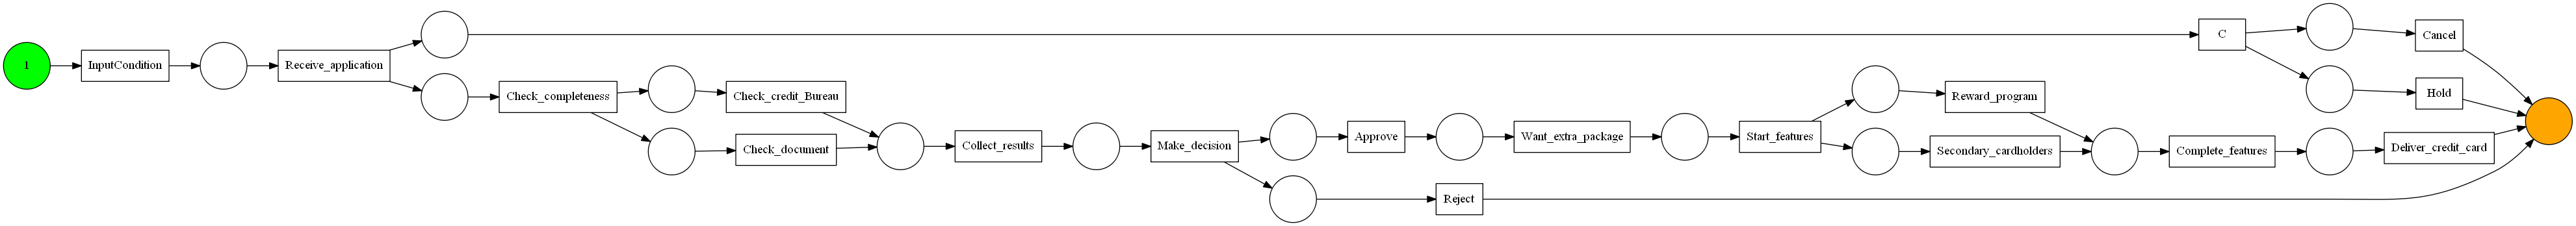

In [6]:
places = []
transitions = []
arcs = []

yawl = Yawl('credit-card-demo.yawl')

#Create all conditions and task's places
conditionID = yawl.inputCondition.attrib['id']

places.append({'id': 'place_' + conditionID, 'initialMarking': True})
transitions.append({'id': conditionID})
arcs.append({'id': '0', 'source': 'place_' + conditionID, 'target': conditionID})

i = 1
for condition in yawl.conditions:
    conditionID = condition.attrib['id']

    places.append({'id': 'place_' + conditionID, 'initialMarking': False})
    transitions.append({'id': conditionID})
    arcs.append({'id': str(i), 'source': 'place_' + conditionID, 'target': conditionID})
    
    i += 1
    
for task in yawl.tasks:
    taskID = task.attrib['id']
    places.append({'id': 'place_' + taskID, 'initialMarking': False})
    transitions.append({'id': taskID})
    arcs.append({'id': str(i), 'source': 'place_' + taskID, 'target': taskID})
    
    i += 1

for outputCondition in yawl.outputConditions:
    conditionID = outputCondition.attrib['id']

    places.append({'id': 'place_' + conditionID, 'initialMarking': False})

#Connect Arcs
for transition in transitions:
    transitionID = transition['id']
    
    for element in yawl.allElements:
        if element.attrib['id'] == transitionID:
            break
            
    placeIDs = []
    
    flowsIntos = element.findall(xmlns + 'flowsInto')
    for flowsInto in flowsIntos:
        placeIDs.append('place_' + flowsInto.find(xmlns + 'nextElementRef').attrib['id'])
        
        
    for placeID in placeIDs:
        arcs.append({'id': str(i), 'source': transitionID, 'target': placeID})
        i += 1
        

pnml = Pnml(places, transitions, arcs)
pnml.writePnml('yawl.pnml')

net, initial_marking, final_marking = pnml_importer.apply('yawl.pnml')
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [91]:
print(arcs)

[{'id': '0', 'source': 'place_InputCondition', 'target': 'transition_InputCondition'}, {'id': '1', 'source': 'place_C', 'target': 'transition_C'}, {'id': '2', 'source': 'place_Receive_application', 'target': 'transition_Receive_application'}, {'id': '3', 'source': 'place_Cancel', 'target': 'transition_Cancel'}, {'id': '4', 'source': 'place_Check_completeness', 'target': 'transition_Check_completeness'}, {'id': '5', 'source': 'place_Hold', 'target': 'transition_Hold'}, {'id': '6', 'source': 'place_Check_credit_Bureau', 'target': 'transition_Check_credit_Bureau'}, {'id': '7', 'source': 'place_Check_document', 'target': 'transition_Check_document'}, {'id': '8', 'source': 'place_Collect_results', 'target': 'transition_Collect_results'}, {'id': '9', 'source': 'place_Make_decision', 'target': 'transition_Make_decision'}, {'id': '10', 'source': 'place_Approve', 'target': 'transition_Approve'}, {'id': '11', 'source': 'place_Reject', 'target': 'transition_Reject'}, {'id': '12', 'source': 'place

In [64]:
places = [{'id': 'start', 'initialMarking': True}, {'id': 'end', 'initialMarking': False}]
transitions = [{"id": 'transicao'}]
arcs = [{'id': '1', 'source': 'start', 'target': 'transicao'}, {'id':'2', 'source': 'transicao', 'target': 'end'}]

pnml = Pnml(places, transitions, arcs)
pnml.writePnml('petri.pnml')

In [70]:
log = xes_importer.apply('running-example.xes')
net, initial_marking, final_marking = alpha_miner.apply(log)
pnml_exporter.apply(net, initial_marking, "running-example.pnml")

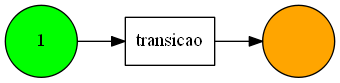

In [61]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [60]:
net, initial_marking, final_marking = pnml_importer.apply('petri.pnml')

In [63]:
pnml_exporter.apply(net, initial_marking, "petri.pnml")